In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
import random
from scipy import signal
import os

class SyntheticDataset(Dataset):
    """
    Creates “composite” samples by mixing multiple signals + noise 
    from a single memmap file. The memmap has fields:
        ('id', np.int32),
        ('audio', np.float32, (max_audio_len,)),
        ('adc1',  np.float32, (max_adc_len,)),
        ('adc2',  np.float32, (max_adc_len,))
    where 'id' = 0 indicates noise, and 'id' > 0 indicates a signal.
    """
    def __init__(
        self,
        descriptor_path: str,
        target_seq_length: int,
        n_signals: tuple = (1, 3),
        transform=None,
    ):
        """
        Args:
            descriptor_path (str): Path to the JSON descriptor for the memmap file.
            target_seq_length (int): Final length of each composite sequence.
            n_signals (tuple): (min, max) number of signal segments to mix in each composite.
        """
        super().__init__()
        self.target_seq_length = target_seq_length
        self.n_signals = n_signals
        self.transform = transform
        
        # 1) Load descriptor and open memmap.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)

        self.memmap_path = self.descriptor['memmap_filename']
        self.n_segments  = self.descriptor['n_segments']
        self.dataset_map = self.descriptor['dataset_mapping']  # {dataset_name: id} or {some_label: id}
        
        # Reconstruct the dtype from 'dtype' in descriptor
        # e.g. dtype = [('id', '<i4'), ('audio', '<f4', (max_audio_len,)), ...]
        descr_list = self.descriptor['dtype']  # list of tuples
        self.dtype = np.dtype([tuple(x) for x in descr_list])

        # Open the memmap
        self.data_memmap = np.memmap(
            self.memmap_path,
            dtype=self.dtype,
            mode='r',
            shape=(self.n_segments,)
        )

        # 2) Split into indices that correspond to noise vs. signal
        #    Here we assume "id=0" means noise, and "id>0" means signal.
        self.noise_indices = []
        self.signal_indices = []
        for i in range(self.n_segments):
            seg_id = self.data_memmap[i]['id']
            if seg_id == 0:
                self.noise_indices.append(i)
            else:
                self.signal_indices.append(i)

        # How many classes do we have? 
        # If your dataset_mapping is {dataset_name: ID}, 
        # then total unique IDs can be gleaned from it:
        self.num_signal_classes = len(set(self.dataset_map.values())) - 1  # minus 1 for 'noise=0'
        self.total_classes = self.num_signal_classes + 1  # (noise + signals)

        # Optionally define how long the dataset should appear to be
        # For example, we can make a large arbitrary length, 
        # or just base it on how many signal segments we have.
        self.synthetic_length = 10000  # or any large number you want

    def __len__(self):
        """Arbitrary size for synthetic dataset."""
        return self.synthetic_length

    def __getitem__(self, idx):
        """
        Dynamically builds a composite sample of length `target_seq_length`.

        Returns:
            adc1_tensor (Tensor of shape [target_seq_length])
            adc2_tensor (Tensor of shape [target_seq_length])
            label_tensor (Tensor of shape [target_seq_length])
        """
        # 1) Decide how many signal segments to add this time
        n_sigs_needed = random.randint(*self.n_signals)

        # 2) Prepare empty arrays for final output
        adc1_full  = np.zeros(self.target_seq_length, dtype=np.float32)
        adc2_full  = np.zeros(self.target_seq_length, dtype=np.float32)
        label_full = np.zeros(self.target_seq_length, dtype=np.int64)  # Store the ID at each sample

        current_pos = 0
        signals_used = 0

        # Randomly decide if we start placing a signal or noise first
        place_signal_first = (random.random() < 0.5)

        # 3) Alternate placing noise / signal until we exhaust n_sigs_needed or fill array
        while current_pos < self.target_seq_length and signals_used < n_sigs_needed:
            if place_signal_first:
                # (A) Pick a random signal from signal_indices
                random_signal_idx = random.choice(self.signal_indices)
                seg_id   = self.data_memmap[random_signal_idx]['id']
                seg_adc1 = self.data_memmap[random_signal_idx]['adc1']
                seg_adc2 = self.data_memmap[random_signal_idx]['adc2']
                
                # (B) Decide how big this chunk is. For simplicity, place entire segment
                # or clip if it doesn't fully fit
                seg_len = min(len(seg_adc1[~np.isinf(seg_adc1)]), 
                              len(seg_adc2[~np.isinf(seg_adc2)]))
                # Remove inf values (padded) from the ends, so we get the real segment length
                seg_len = min(seg_len, self.target_seq_length - current_pos)

                # (C) Copy data to the final array
                #    For the chunk, we only copy up to seg_len
                adc1_full[current_pos: current_pos + seg_len] = seg_adc1[:seg_len]
                adc2_full[current_pos: current_pos + seg_len] = seg_adc2[:seg_len]
                label_full[current_pos: current_pos + seg_len] = seg_id  # signal ID
                
                current_pos += seg_len
                signals_used += 1
            else:
                # (D) Place noise
                random_noise_idx = random.choice(self.noise_indices)
                noise_id   = self.data_memmap[random_noise_idx]['id']  # should be 0
                noise_adc1 = self.data_memmap[random_noise_idx]['adc1']
                noise_adc2 = self.data_memmap[random_noise_idx]['adc2']

                noise_len = min(len(noise_adc1[~np.isinf(noise_adc1)]),
                                len(noise_adc2[~np.isinf(noise_adc2)]))
                noise_len = min(noise_len, self.target_seq_length - current_pos)

                adc1_full[current_pos : current_pos + noise_len] = noise_adc1[:noise_len]
                adc2_full[current_pos : current_pos + noise_len] = noise_adc2[:noise_len]
                label_full[current_pos : current_pos + noise_len] = noise_id  # 0 = noise

                current_pos += noise_len

            # Flip between signal ↔ noise
            place_signal_first = not place_signal_first

        # 4) If we’ve placed all signals but still have space, fill the rest with noise
        while current_pos < self.target_seq_length:
            random_noise_idx = random.choice(self.noise_indices)
            noise_id   = self.data_memmap[random_noise_idx]['id']  # 0
            noise_adc1 = self.data_memmap[random_noise_idx]['adc1']
            noise_adc2 = self.data_memmap[random_noise_idx]['adc2']

            noise_len = min(len(noise_adc1[~np.isinf(noise_adc1)]),
                            len(noise_adc2[~np.isinf(noise_adc2)]))
            noise_len = min(noise_len, self.target_seq_length - current_pos)

            adc1_full[current_pos : current_pos + noise_len] = noise_adc1[:noise_len]
            adc2_full[current_pos : current_pos + noise_len] = noise_adc2[:noise_len]
            label_full[current_pos : current_pos + noise_len] = noise_id  # 0

            current_pos += noise_len

        adc1_full = BPfilter(adc1_full, fs=8000, lowcut_hz=5, highcut_hz=3700)
        adc2_full = BPfilter(adc2_full, fs=8000, lowcut_hz=5, highcut_hz=3700)

        # 5) Convert to torch Tensors
        adc1_tensor  = torch.from_numpy(adc1_full.copy()).float()
        adc2_tensor  = torch.from_numpy(adc2_full.copy()).float()
        label_tensor = torch.from_numpy(label_full.copy())

        # 6) Apply transformations if any
        if self.transform:
            label_tensor, adc1_tensor, adc2_tensor = self.transform((label_tensor, adc1_tensor, adc2_tensor))

        return adc1_tensor, adc2_tensor, label_tensor

    def get_N_classes(self):
        """Returns total number of classes"""
        return self.total_classes

    def id_to_dataset(self, id_val):
        """
        Return the dataset string for the given ID, 
        or "Noise" if id=0 is your noise class.
        """
        if id_val == 0:
            return "noise"
        # Reverse lookup from dataset_mapping
        for k, v in self.dataset_map.items():
            if v == id_val:
                return k
        return "Unknown"

def BPfilter( data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        return filtered_data

class normalizer():
    def __init__(self, mean, std, augment=None):
        self.mean = mean
        self.std = std
        self.augment = augment

    def __call__(self, sample):
        id, adc1, adc2 = sample
        # audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[0]) / (self.std[0]*10)
        adc2 = (adc2 - self.mean[0]) / (self.std[0]*10)
        if self.augment is not None:
            # apply augmentation = random frequency nosie
            r_freq = torch.rand(1).item() * (200 - 0.1) + 0.1
            noise = torch.sin(2 * torch.pi * r_freq * torch.arange(len(adc1), dtype=torch.float32) / 16000) * 0.03
            adc1 += noise * torch.rand(1).item() * (1.1 - 0.9) + 0.1
            adc2 += noise * torch.rand(1).item() * (1.1 - 0.9) + 0.1
        return id, adc1, adc2

desc_path = "train_descriptor.json"  # the descriptor you just generated
seq_len = 16000
dataset = SyntheticDataset(descriptor_path=desc_path, target_seq_length=seq_len, n_signals=(2,3))
transform = normalizer(mean=[dataset.descriptor['adc_mean']], std=[dataset.descriptor['adc_std']], augment=False)
dataset.transform = transform
print("Dataset length:", len(dataset))
print("Total classes:", dataset.get_N_classes())
sample_adc1, sample_adc2, sample_labels = dataset[0]
print(sample_adc1.shape, sample_adc2.shape, sample_labels.shape)


Dataset length: 10000
Total classes: 43
torch.Size([16000]) torch.Size([16000]) torch.Size([16000])


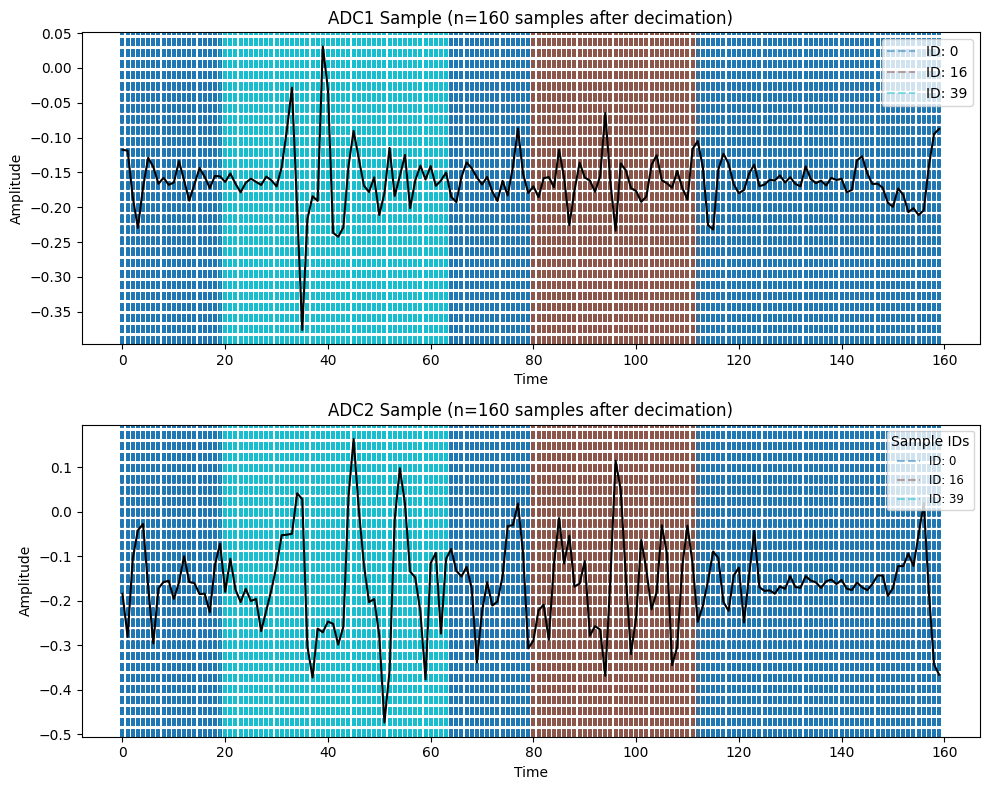

In [2]:
from scipy.signal import decimate

import matplotlib.pyplot as plt

n_decimate = 100  # Decimation factor

rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

adc1, adc2, sample_id = sample  # unpack the tuple

# Decimate the signals for display
adc1_decimated = decimate(adc1.numpy(), n_decimate, zero_phase=True)
adc2_decimated = decimate(adc2.numpy(), n_decimate, zero_phase=True)
sample_id_decimated = decimate(sample_id.numpy(), n_decimate, zero_phase=True, ftype='iir')

# Create a figure with two subplots for ADC1 and ADC2.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Add colored vertical lines for the sample_id
unique_ids = torch.unique(sample_id)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ids)))  # Generate distinct colors for each unique ID

for unique_id, color in zip(unique_ids, colors):
    indices = (sample_id == unique_id).nonzero(as_tuple=True)[0].numpy()  # Get indices for the current ID
    indices_decimated = indices // n_decimate  # Adjust indices for decimation
    for idx in indices_decimated:
        axs[0].axvline(x=idx, color=color, linestyle='--', alpha=0.5, label=f"ID: {unique_id.item()}")
        axs[1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

# Add legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
axs[0].legend(by_label.values(), by_label.keys(), loc='upper right')
axs[0].plot(adc1_decimated, color='black', label='ADC1')
axs[0].set_title(f"ADC1 Sample (n={len(adc1_decimated)} samples after decimation)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small', title="Sample IDs")
axs[1].plot(adc2_decimated, color='black', label='ADC2')
axs[1].set_title(f"ADC2 Sample (n={len(adc2_decimated)} samples after decimation)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [3]:
import json
import os
import random

import torch
from torch.utils.data import Dataset
import numpy as np

class TestDataset(Dataset):
    """
    A Dataset for your test memmap. 
    Each row in the memmap has:
      - 'id': int32
      - 'segments': int32, (max_n_segments, 2) 
      - 'audio': float32, (max_audio_seq_len,)
      - 'adc1':  float32, (max_adc_seq_len,)
      - 'adc2':  float32, (max_adc_seq_len,)

    This Dataset:
      - Skips rows that are pure noise (id=0) (or you can handle them differently).
      - For labeled rows (id != 0), picks a random segment from 'segments'
        and ensures that the chosen crop overlaps that segment.
      - Returns (adc1_tensor, adc2_tensor, label_tensor)
        just like your synthetic train set.
    """

    def __init__(self, descriptor_path: str, target_seq_length: int, skip_noise_rows: bool = True, transform=None):
        """
        Args:
            descriptor_path (str): path to the test descriptor JSON (e.g., "test_descriptor.json").
            target_seq_length (int): how many samples to crop from each row's full sequence.
            skip_noise_rows (bool): if True, we ignore rows where id=0 (pure noise).
        """
        super().__init__()
        self.target_seq_length = target_seq_length
        self.skip_noise_rows = skip_noise_rows
        self.transform = transform
        
        # 1) Load descriptor
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        self.memmap_path = self.descriptor['memmap_filename']
        self.n_rows = self.descriptor['n_datasets']  # how many rows in the test memmap
        
        # Rebuild dtype
        descr_list = self.descriptor['dtype']
        self.dtype = np.dtype([tuple(x) for x in descr_list])

        # 2) Open the memmap
        self.data_memmap = np.memmap(
            self.memmap_path,
            dtype=self.dtype,
            mode='r',
            shape=(self.n_rows,)
        )
        
        # Collect valid indices:
        #   - If skip_noise_rows==True, filter out rows that have id=0
        #   - If skip_noise_rows==False, keep them but we might still only sample the labeled portion
        self.valid_indices = []
        for i in range(self.n_rows):
            row_id = self.data_memmap[i]['id']
            if (row_id == 0) and skip_noise_rows:
                # skip purely noise row
                continue
            self.valid_indices.append(i)
        
        # We'll interpret len(dataset) as number of valid rows
        self._actual_length = len(self.valid_indices)

        self.dataset_mapping = self.descriptor.get('dataset_mapping', {})
        self.all_ids = set(self.dataset_mapping.values())  # numeric IDs
        self.num_classes = len(self.all_ids)  # total distinct IDs in mapping
        self.dataset_map = self.descriptor['dataset_mapping']  # {dataset_name: id} or {some_label: id}

    def __len__(self):
        """Return count of valid rows (excluding pure-noise rows if skip_noise_rows=True)."""
        return self._actual_length*10


    def __getitem__(self, idx):
        """
        Returns one random crop from the entire sequence in the memmap row. 
        Ensures it has a labeled portion for rows with id != 0.
        """
        idx = idx % self._actual_length  # wrap around if idx >= actual length
        # 1) Map 'idx' to the correct row index in the memmap
        memmap_index = self.valid_indices[idx]
        row = self.data_memmap[memmap_index]
        
        row_id       = row['id']   # label ID
        row_segments = row['segments']  # (max_n_segments, 2)
        adc1_full    = row['adc1']
        adc2_full    = row['adc2']
        full_length  = len(adc1_full)  # or you might check where real data ends, ignoring zeros
        
        # 2) If row_id=0 (which means we didn't skip noise rows), 
        #    then we can just pick a random crop anywhere (it'll be noise).
        #    If row_id != 0, we want to ensure overlap with at least one (start,end).
        
        if row_id != 0:
            # Filter out empty segments
            valid_segments = [(s0//12, s1//12) for (s0,s1) in row_segments if not (s0==0 and s1==0)]
            # We pick exactly one segment randomly to anchor our crop
            seg_start, seg_end = random.choice(valid_segments)
            seg_len = seg_end - seg_start

            # If that segment is smaller than the target_seq_length,
            # we pick a random start that *overlaps* with [seg_start, seg_end].
            # E.g. we can shift up to half the difference, or an entire difference.
            # One simple approach: we want the final crop [start_idx, end_idx) 
            # to intersect [seg_start, seg_end) at least partially.

            # We'll clamp the start_idx so that [start_idx, start_idx+target_seq_length) 
            # intersects [seg_start, seg_end].
            # A quick approach:
            #   possible_min = seg_end - target_seq_length
            #   possible_max = seg_start
            #
            # Then choose a random start in [possible_min, possible_max].
            # We also clamp within [0, full_length - target_seq_length].

            possible_min = seg_end - self.target_seq_length
            possible_max = seg_start

            # If the segment is actually bigger than target_seq_length, 
            # possible_min < possible_max. 
            # If the segment is smaller, we might still do some partial overlap.

            # Let's define global min, max for start_idx
            global_min = 0
            global_max = max(0, full_length - self.target_seq_length)

            # We want the intersection of [possible_min, possible_max] and [global_min, global_max]
            real_min = max(global_min, possible_min)
            real_max = min(global_max, possible_max)

            if real_min > real_max:
                # Means we cannot find a start that perfectly intersects. 
                # Let's fallback to a random start in [0, global_max]
                start_idx = random.randint(global_min, global_max) if global_max>=0 else 0
            else:
                start_idx = random.randint(real_min, real_max)
        else:
            # row_id=0 => pure noise row. Just pick any random start
            if self.target_seq_length >= full_length:
                start_idx = 0
            else:
                start_idx = random.randint(0, full_length - self.target_seq_length)

        end_idx = start_idx + self.target_seq_length

        # 3) Extract the data
        adc1_crop = adc1_full[start_idx:end_idx]
        adc2_crop = adc2_full[start_idx:end_idx]
        
        if len(adc1_crop) < self.target_seq_length:
            pad_len = self.target_seq_length - len(adc1_crop)
            adc1_crop = np.concatenate([adc1_crop, np.zeros(pad_len, dtype=np.float32)])
            adc2_crop = np.concatenate([adc2_crop, np.zeros(pad_len, dtype=np.float32)])
        
        # 4) Build label array. Initialize with 0 (noise).
        label_crop = np.zeros(self.target_seq_length, dtype=np.int64)
        
        # Mark labeled region if id != 0
        if row_id != 0:
            for (s0, s1) in row_segments:
                if s0 == 0 and s1 == 0:
                    continue  # skip empty
                overlap_start = max(s0//12, start_idx)
                overlap_end   = min(s1//12, end_idx)
                if overlap_start < overlap_end:
                    # Convert to local indices in the crop
                    local_start = overlap_start - start_idx
                    local_end   = overlap_end   - start_idx
                    label_crop[local_start:local_end] = row_id
        # If row_id=0, label_crop remains all zeros

        adc1_crop = BPfilter(adc1_crop, fs=8000, lowcut_hz=5, highcut_hz=3700)
        adc2_crop = BPfilter(adc2_crop, fs=8000, lowcut_hz=5, highcut_hz=3700)
        # 5) Convert to torch
        adc1_tensor  = torch.from_numpy(adc1_crop.copy()).float()
        adc2_tensor  = torch.from_numpy(adc2_crop.copy()).float()
        label_tensor = torch.from_numpy(label_crop.copy())

        # 6) Apply transformations if any
        if self.transform:
            label_tensor, adc1_tensor, adc2_tensor = self.transform((label_tensor, adc1_tensor, adc2_tensor))
        
        return adc1_tensor, adc2_tensor, label_tensor

    def get_N_classes(self):
        """Number of distinct classes (including noise)."""
        return self.num_classes
    
    def id_to_dataset(self, id_val):
        """Reverse lookup from numeric ID to string dataset name."""
        for dataset_name, dataset_id in self.dataset_mapping.items():
            if dataset_id == id_val:
                return dataset_name
        return "Unknown"



descriptor_test = "test_descriptor.json"
test_transform = normalizer(
    mean=transform.mean,
    std=transform.std,
    augment=False  # No augmentation for test dataset
)
test_dataset = TestDataset(descriptor_test, seq_len, skip_noise_rows=True, transform= transform)

print("Number of test items:", len(test_dataset))
print("Number of classes:", test_dataset.get_N_classes())

adc1, adc2, label = test_dataset[0]
print("Shapes:", adc1.shape, adc2.shape, label.shape)

# Suppose we want to see the dataset name for a particular label ID
print("ID -> dataset name:", test_dataset.id_to_dataset(label[101].item()))


Number of test items: 840
Number of classes: 43
Shapes: torch.Size([16000]) torch.Size([16000]) torch.Size([16000])
ID -> dataset name: noise


In [4]:
rng_index = np.random.randint(0, len(test_dataset))
sample = test_dataset[rng_index]

adc1, adc2, sample_id = sample  # unpack the tuple

unique_labels = np.unique(sample_id.numpy())
print("Unique labels in sample:", unique_labels)

Unique labels in sample: [ 0 15]


Unique labels in sample: [0 7]


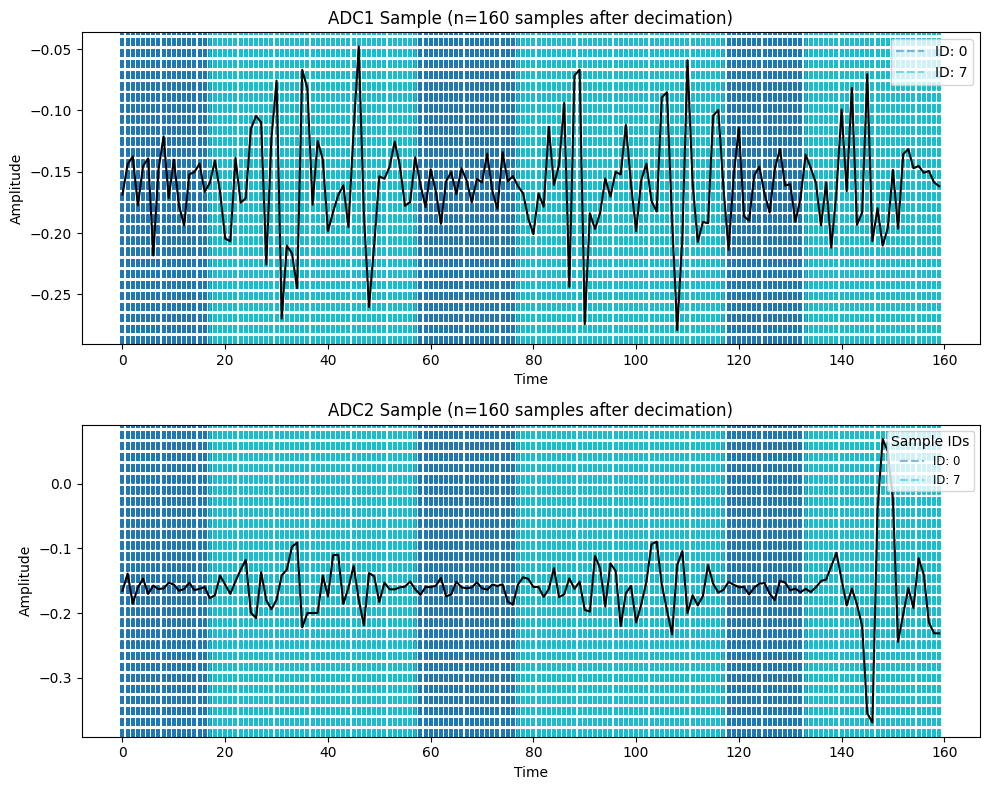

In [5]:
from scipy.signal import decimate

import matplotlib.pyplot as plt

n_decimate = 100  # Decimation factor

rng_index = np.random.randint(0, len(test_dataset))
sample = test_dataset[rng_index]

adc1, adc2, sample_id = sample  # unpack the tuple
adc1 += np.random.normal(0, 0.01, adc1.shape)  # Adding a small noise for better visualization
adc2 += np.random.normal(0, 0.01, adc2.shape)  # Adding a small noise for better visualization
# Decimate the signals for display
adc1_decimated = decimate(adc1.numpy(), n_decimate, zero_phase=True)
adc2_decimated = decimate(adc2.numpy(), n_decimate, zero_phase=True)
sample_id_decimated = decimate(sample_id.numpy(), n_decimate, zero_phase=True, ftype='iir')
unique_labels = np.unique(sample_id.numpy())
print("Unique labels in sample:", unique_labels)

# Create a figure with two subplots for ADC1 and ADC2.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Add colored vertical lines for the sample_id
unique_ids = torch.unique(sample_id)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ids)))  # Generate distinct colors for each unique ID

for unique_id, color in zip(unique_ids, colors):
    indices = (sample_id == unique_id).nonzero(as_tuple=True)[0].numpy()  # Get indices for the current ID
    indices_decimated = indices // n_decimate  # Adjust indices for decimation
    for idx in indices_decimated:
        axs[0].axvline(x=idx, color=color, linestyle='--', alpha=0.5, label=f"ID: {unique_id.item()}")
        axs[1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

# Add legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
axs[0].legend(by_label.values(), by_label.keys(), loc='upper right')
axs[0].plot(adc1_decimated, color='black', label='ADC1')
axs[0].set_title(f"ADC1 Sample (n={len(adc1_decimated)} samples after decimation)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small', title="Sample IDs")
axs[1].plot(adc2_decimated, color='black', label='ADC2')
axs[1].set_title(f"ADC2 Sample (n={len(adc2_decimated)} samples after decimation)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [ ]:
from torch import nn
import math
from torchviz import make_dot

def compute_model_size(model, input_tensor):
    """
    Computes the size of the model in MB.
    Args:
        model: The PyTorch model.
        input_tensor: A sample input tensor to pass through the model.
    Returns:
        size_in_mb: Size of the model in MB.
    """
    num_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = num_params * 4  # Assuming float32 (4 bytes)
    size_in_mb = size_in_bytes / (1024 ** 2)
    return size_in_mb

class SinusoidalPositionalEncoding(nn.Module):
    """
    Implements the classic sinusoidal positional encoding as described in the 
    "Attention is All You Need" paper (Vaswani et al., 2017).
    """
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        
        # Create a long enough P x D matrix of sinusoidal signals
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # [d_model/2]
        
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        # Even indices: 2i
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices: 2i+1
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer so it doesn't get updated during backprop
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x is assumed to be of shape [batch_size, seq_len, d_model].
        We want to add positional encoding to each position in the sequence.
        """
        seq_len = x.size(1)  # how many tokens in the sequence dimension
        # Add the positional embedding up to seq_len
        pos_emb = self.pe[:seq_len, :]  # shape [seq_len, d_model]
        # We need shape to match x: [B, seq_len, d_model]
        return x + pos_emb.unsqueeze(0)


class V1dTransformer(nn.Module):
    def __init__(self, 
                 input_dim,
                 output_dim,
                 max_length,
                 input_kern = 16,  # Kernel size for the initial Conv1d layer
                 nhead=8, 
                 num_encoder_layers=6, 
                 dim_feedforward=512, 
                 dropout=0.1):
        super(V1dTransformer, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_kern = input_kern  # Kernel size for the initial Conv1d layer
        self.stride = input_kern      # Stride for the Conv1d layer, typically half of kernel size
        # conv sequence
        self.conv = nn.Conv1d(input_dim, dim_feedforward//2, kernel_size=self.input_kern, stride=self.stride)
        self.convAcivation = nn.GELU()
        self.conv2 = nn.Conv1d(dim_feedforward//2, dim_feedforward, kernel_size=1)
        # self.posencoding = nn.Embedding(10000, dim_feedforward)  # Positional encoding for up to 1000 positions
        self.pos_encoding = SinusoidalPositionalEncoding(dim_feedforward, max_len=(max_length-self.input_kern)//self.stride + 1)  # Adjust max_len based on stride
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim_feedforward,
                nhead=nhead,
                dim_feedforward=dim_feedforward*2,
                dropout=dropout,
                batch_first=True  # Set to True to match the input shape (batch_size, seq_length, d_model
            ),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(dim_feedforward, output_dim)

        # self.special_token = nn.Embedding(1, dim_feedforward)  # Special token embedding for the special token
    
    def forward(self, x):
        """
        x: shape [B, 2, T]  (two ADC channels)
        special_token_positions_batch: list of lists of integers
        - E.g. [[2, 10], [0, 3, 5], ..., [1]] 
        - where each sub-list is for one sample in the batch.
        """

        # 1) Convolution => [B, dim_feedforward, new_seq_len]
        x = self.conv(x)
        # print("after conv", x.shape)
        x = self.convAcivation(x)
        # print("after act", x.shape)
        x = self.conv2(x)
        # print("after 2nd conv", x.shape)
        
        # 2) Permute => [B, new_seq_len, dim_feedforward]
        x = x.permute(0, 2, 1)

        # 4) Add positional encoding => [B, new_seq_len, dim_feedforward]
        x = self.pos_encoding(x)
        # print("after encoding", x.shape)
        
        # 5) Transformer => [B, new_seq_len, dim_feedforward]
        x = self.transformer_encoder(x)
        # print("after transformer", x.shape)
        # 6) Final projection => [B, new_seq_len, output_dim]
        x = self.fc_out(x)
        # print("final", x.shape)

        return x


dummy_input = torch.randn(64,2, seq_len)


model = V1dTransformer(
    input_dim=2,  # Two input channels: adc1 and adc2
    output_dim=dataset.get_N_classes(),  # Number of classes
    max_length=seq_len,  # Maximum sequence length
    input_kern=32,  # Kernel size for the initial Conv1d layer
    nhead=4, 
    num_encoder_layers=2, 
    dim_feedforward=256, 
    dropout=0.3
)


output = model(dummy_input)

print("Output shape:", output.shape)
print("\n\n")
print("Model size (MB):", compute_model_size(model, dummy_input))
print("\nModel summary:\n")
print(model)

# make_dot(output, params=dict(list(model.named_parameters()) + (list(model.pos_encoding.named_parameters())))).render("v1dTransformer", format="png")


Output shape: torch.Size([64, 1000, 43])



Model size (MB): 4.205730438232422

Model summary:

V1dTransformer(
  (conv): Conv1d(2, 128, kernel_size=(16,), stride=(16,))
  (convAcivation): GELU(approximate='none')
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (pos_encoding): SinusoidalPositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p

In [7]:
import torch
import torch.nn as nn
from tqdm import tqdm

def train_epochs(
    model,
    dataloader,
    epochs,
    optimizer,
    scheduler,
    loss_func,
    device='cpu',
    verbose=True
):
    """
    Trains `model` for `epochs` epochs on `dataloader`.
    Returns the final epoch's average loss and accuracy.
    """
    model.to(device)

    for epoch in range(epochs):
        model.train()  # set model to training mode
        total_loss = 0.0
        total_correct = 0
        total_tokens = 0
        num_batches = 0

        # Optionally wrap the dataloader in a tqdm iterator
        loop_desc = f"Epoch {epoch+1}/{epochs}"
        loader_iter = tqdm(dataloader, desc=loop_desc, disable=not verbose)

        for adc1, adc2, ids in loader_iter:
            # 1) Move data to device
            adc1 = adc1.to(device)  # shape: [B, T]
            adc2 = adc2.to(device)  # shape: [B, T]
            ids  = ids.to(device)   # shape: [B, T]  (class IDs at each time step)

            # 2) (Optional) downsample the labels if your model downsamples the time axis
            #    e.g., if model.input_kern=4, we do:
            ids = ids[:, :: model.input_kern]
            # randomly scale adc1 and adc2 
            # 3) Combine ADC channels => shape [B, 2, T]
            adc = torch.stack((adc1, adc2), dim=1)
            adc = adc + torch.randn_like(adc) * 0.02  # Adding a small amount of noise for robustness
            # 4) Forward pass => logits of shape [B, T', num_classes]
            logits = model(adc)

            # Make sure shape is correct for cross-entropy
            # a) Flatten approach:
            B, T_prime, C = logits.shape
            # Flatten => [B*T', C],  target => [B*T']
            logits_2d = logits.view(B*T_prime, C)
            ids_1d    = ids.view(-1)

            # 5) Compute loss
            # loss = loss_func(logits_2d, ids_1d)
            loss = loss_func(logits_2d, ids_1d)

            # 6) Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 7) Accuracy
            with torch.no_grad():
                pred = logits.argmax(dim=2)        # shape [B, T']
                correct = (pred == ids).sum().item()
                total_correct += correct
                total_tokens  += (B * T_prime)

            total_loss += loss.item()
            num_batches += 1

            if verbose:
                acc_batch = 100.0 * correct / (B * T_prime)
                loader_iter.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{acc_batch:.2f}%"
                })

        # 8) Step the scheduler after each epoch (if not using per-step scheduling)
        if scheduler is not None:
            scheduler.step()

        # End of epoch stats
        avg_loss = total_loss / max(num_batches, 1)
        accuracy = 100.0 * total_correct / max(total_tokens, 1)
        if verbose:
            print(f"[Epoch {epoch+1}/{epochs}] Loss: {avg_loss:.4f}, Acc: {accuracy:.2f}%")

    return avg_loss, accuracy

def evaluate_model(
    model,
    dataloader,
    loss_func,
    device='cpu',
    verbosity=1
):
    """
    Evaluates `model` on `dataloader` without training updates.
    Returns (average loss, accuracy).
    """
    model.to(device)
    model.eval()  # set model to evaluation mode

    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    num_batches = 0

    with torch.no_grad():
        for adc1, adc2, ids in tqdm(dataloader, desc="Evaluating", disable=(verbosity==0)):
            # Move to device
            adc1 = adc1.to(device)
            adc2 = adc2.to(device)
            ids  = ids.to(device)

            # Downsample IDs if needed
            ids = ids[:, :: model.input_kern]

            # Build input => shape [B, 2, T]
            adc = torch.stack((adc1, adc2), dim=1)

            # Forward pass => shape [B, T', C]
            logits = model(adc)

            B, T_prime, C = logits.shape
            logits_2d = logits.view(B*T_prime, C)
            ids_1d    = ids.view(-1)

            # Loss
            loss = loss_func(logits_2d, ids_1d)
            total_loss += loss.item()

            # Accuracy
            pred = logits.argmax(dim=2)
            total_correct += (pred == ids).sum().item()
            total_tokens  += (B * T_prime)
            num_batches   += 1

    avg_loss = total_loss / max(num_batches, 1)
    accuracy = 100.0 * total_correct / max(total_tokens, 1)

    if verbosity > 0:
        print(f"Evaluation => Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy


In [8]:
from torch.utils.data import DataLoader, random_split

#! Create DataLoader instances for training and validation sets
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids.shape)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_loader)}")
print(f"Number of validation samples: {len(val_loader)}")


Batch 1:
IDs: torch.Size([64, 16000])
ADC1 shape: torch.Size([64, 16000])
ADC2 shape: torch.Size([64, 16000])
Batch 2:
IDs: torch.Size([64, 16000])
ADC1 shape: torch.Size([64, 16000])
ADC2 shape: torch.Size([64, 16000])
Batch 1:
IDs: torch.Size([64, 16000])
ADC1 shape: torch.Size([64, 16000])
ADC2 shape: torch.Size([64, 16000])
Batch 2:
IDs: torch.Size([64, 16000])
ADC1 shape: torch.Size([64, 16000])
ADC2 shape: torch.Size([64, 16000])
Number of training samples: 156
Number of validation samples: 13


In [9]:
# !wandb login

In [10]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [11]:
TOTAL_EPOCHS = 512
PER_EPOCH = 1

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
weights = torch.ones(dataset.get_N_classes())  # Weight for each class
weights[0] = 1/(dataset.get_N_classes()*2.0)  # Give less weight to the noise class
weights[-4] = 2/3  # Give less weight to the noise class
weights[-3] = 2/3  # Give less weight to the noise class
weights[-2] = 2/3  # Give less weight to the noise class
weights[-1] = 2/3  # Give less weight to the noise class
criterion = torch.nn.CrossEntropyLoss(weight=weights)#, label_smoothing=0.2)  # Use label smoothing for better generalization
# criterion = torch.nn.CTCLoss(
#     blank=0,  # Assuming class 0 is the blank label for CTC
#     zero_infinity=True,
# )
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
# scheduler = None
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", global_device)
verbosity = 1
criterion = criterion.to(global_device)

Using device: cuda:0


In [ ]:
# the actual training loop
train_stats = []
test_stats = []
best_accuracy = 0.0  # Initialize the best accuracy

for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res = train_epochs(model, 
                     train_loader, 
                     epochs=PER_EPOCH, 
                     optimizer=optimizer,
                     scheduler=scheduler,
                     loss_func=criterion,
                     device=global_device,
                    #  verbose=epoch % 10 == 0 
                     verbose=1
                     )
    train_stats.append(res)
    res = evaluate_model(
        model,
        val_loader,
        loss_func=criterion,
        device=global_device,
        verbosity=verbosity
    )
    test_stats.append(res)
    
    # Check if the current accuracy is better than the best accuracy
    current_accuracy = res[1]
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        torch.save(model.state_dict(), "best_v1dTransformer.pth")  # Save the model
        print(f"\nNew best accuracy: {best_accuracy:.2f}%. Model saved.\n")


Epoch 1/1: 100%|██████████| 156/156 [00:21<00:00,  7.36it/s, loss=3.7702, acc=1.11%]


[Epoch 1/1] Loss: 3.8079, Acc: 1.35%


TOTAL Epochs:   0%|          | 1/512 [00:22<3:09:32, 22.26s/it]

Evaluation => Loss: 3.7828, Accuracy: 1.35%

New best accuracy: 1.35%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:21<00:00,  7.09it/s, loss=3.7475, acc=1.20%]


[Epoch 1/1] Loss: 3.7785, Acc: 1.32%


TOTAL Epochs:   0%|          | 2/512 [00:43<3:05:28, 21.82s/it]

Evaluation => Loss: 3.7788, Accuracy: 1.52%

New best accuracy: 1.52%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.06it/s, loss=3.7684, acc=1.16%]


[Epoch 1/1] Loss: 3.7648, Acc: 1.80%


TOTAL Epochs:   1%|          | 3/512 [01:06<3:09:55, 22.39s/it]

Evaluation => Loss: 3.7652, Accuracy: 1.44%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.58it/s, loss=3.7212, acc=2.68%]


[Epoch 1/1] Loss: 3.7585, Acc: 3.10%


TOTAL Epochs:   1%|          | 4/512 [01:28<3:06:48, 22.06s/it]

Evaluation => Loss: 3.7673, Accuracy: 2.87%

New best accuracy: 2.87%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=3.6696, acc=3.11%]


[Epoch 1/1] Loss: 3.7332, Acc: 5.42%


TOTAL Epochs:   1%|          | 5/512 [01:50<3:05:05, 21.90s/it]

Evaluation => Loss: 3.7351, Accuracy: 2.06%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.03it/s, loss=3.4804, acc=3.93%]


[Epoch 1/1] Loss: 3.5551, Acc: 4.87%


TOTAL Epochs:   1%|          | 6/512 [02:13<3:08:25, 22.34s/it]

Evaluation => Loss: 3.8153, Accuracy: 3.46%

New best accuracy: 3.46%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.57it/s, loss=3.4926, acc=4.76%]


[Epoch 1/1] Loss: 3.4803, Acc: 6.54%


TOTAL Epochs:   1%|▏         | 7/512 [02:34<3:05:57, 22.09s/it]

Evaluation => Loss: 3.8493, Accuracy: 4.10%

New best accuracy: 4.10%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.57it/s, loss=3.3791, acc=8.65%]


[Epoch 1/1] Loss: 3.3543, Acc: 9.77%


TOTAL Epochs:   2%|▏         | 8/512 [02:56<3:04:17, 21.94s/it]

Evaluation => Loss: 3.8200, Accuracy: 6.99%

New best accuracy: 6.99%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.53it/s, loss=3.1681, acc=11.01%]


[Epoch 1/1] Loss: 3.2108, Acc: 11.22%


TOTAL Epochs:   2%|▏         | 9/512 [03:18<3:03:16, 21.86s/it]

Evaluation => Loss: 3.7559, Accuracy: 6.89%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.03it/s, loss=3.2286, acc=11.73%]


[Epoch 1/1] Loss: 3.0881, Acc: 12.49%


TOTAL Epochs:   2%|▏         | 10/512 [03:41<3:06:22, 22.28s/it]

Evaluation => Loss: 3.7538, Accuracy: 9.37%

New best accuracy: 9.37%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.57it/s, loss=2.9616, acc=17.73%]


[Epoch 1/1] Loss: 3.1213, Acc: 11.32%


TOTAL Epochs:   2%|▏         | 11/512 [04:02<3:04:17, 22.07s/it]

Evaluation => Loss: 3.7730, Accuracy: 13.72%

New best accuracy: 13.72%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.57it/s, loss=2.8671, acc=11.83%]


[Epoch 1/1] Loss: 2.9813, Acc: 13.31%


TOTAL Epochs:   2%|▏         | 12/512 [04:24<3:02:40, 21.92s/it]

Evaluation => Loss: 3.8584, Accuracy: 6.64%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.04it/s, loss=2.6798, acc=15.39%]


[Epoch 1/1] Loss: 2.8588, Acc: 15.36%


TOTAL Epochs:   3%|▎         | 13/512 [04:47<3:05:22, 22.29s/it]

Evaluation => Loss: 3.9806, Accuracy: 8.49%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=2.6175, acc=15.38%]


[Epoch 1/1] Loss: 2.6922, Acc: 17.78%


TOTAL Epochs:   3%|▎         | 14/512 [05:09<3:03:22, 22.09s/it]

Evaluation => Loss: 3.9423, Accuracy: 7.53%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.56it/s, loss=2.4064, acc=22.46%]


[Epoch 1/1] Loss: 2.5501, Acc: 19.91%


TOTAL Epochs:   3%|▎         | 15/512 [05:30<3:01:51, 21.95s/it]

Evaluation => Loss: 4.0387, Accuracy: 11.79%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.54it/s, loss=2.2246, acc=19.38%]


[Epoch 1/1] Loss: 2.3835, Acc: 22.10%


TOTAL Epochs:   3%|▎         | 16/512 [05:52<3:00:47, 21.87s/it]

Evaluation => Loss: 4.0092, Accuracy: 8.22%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.02it/s, loss=2.1193, acc=28.50%]


[Epoch 1/1] Loss: 2.2269, Acc: 23.73%


TOTAL Epochs:   3%|▎         | 17/512 [06:15<3:03:44, 22.27s/it]

Evaluation => Loss: 4.2858, Accuracy: 15.57%

New best accuracy: 15.57%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.54it/s, loss=1.9799, acc=27.25%]


[Epoch 1/1] Loss: 2.1374, Acc: 25.24%


TOTAL Epochs:   4%|▎         | 18/512 [06:37<3:01:52, 22.09s/it]

Evaluation => Loss: 4.1985, Accuracy: 11.12%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.57it/s, loss=1.8362, acc=28.53%]


[Epoch 1/1] Loss: 2.0085, Acc: 27.27%


TOTAL Epochs:   4%|▎         | 19/512 [06:59<3:00:13, 21.93s/it]

Evaluation => Loss: 4.3282, Accuracy: 11.99%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.02it/s, loss=1.7743, acc=30.14%]


[Epoch 1/1] Loss: 1.8663, Acc: 29.42%


TOTAL Epochs:   4%|▍         | 20/512 [07:22<3:02:59, 22.32s/it]

Evaluation => Loss: 4.4159, Accuracy: 12.16%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=1.9509, acc=31.44%]


[Epoch 1/1] Loss: 1.7955, Acc: 30.69%


TOTAL Epochs:   4%|▍         | 21/512 [07:43<3:01:04, 22.13s/it]

Evaluation => Loss: 4.3909, Accuracy: 16.33%

New best accuracy: 16.33%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=1.6150, acc=33.86%]


[Epoch 1/1] Loss: 1.6945, Acc: 32.13%


TOTAL Epochs:   4%|▍         | 22/512 [08:05<2:59:32, 21.98s/it]

Evaluation => Loss: 4.3367, Accuracy: 15.89%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=1.4389, acc=37.79%]


[Epoch 1/1] Loss: 1.6079, Acc: 33.41%


TOTAL Epochs:   4%|▍         | 23/512 [08:27<2:58:26, 21.89s/it]

Evaluation => Loss: 4.3878, Accuracy: 18.41%

New best accuracy: 18.41%. Model saved.



Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.02it/s, loss=1.4747, acc=35.77%]


[Epoch 1/1] Loss: 1.5192, Acc: 34.80%


TOTAL Epochs:   5%|▍         | 24/512 [08:50<3:01:16, 22.29s/it]

Evaluation => Loss: 4.4189, Accuracy: 16.49%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.56it/s, loss=1.3955, acc=36.88%]


[Epoch 1/1] Loss: 1.4690, Acc: 35.39%


TOTAL Epochs:   5%|▍         | 25/512 [09:12<2:59:15, 22.09s/it]

Evaluation => Loss: 4.7595, Accuracy: 11.98%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.54it/s, loss=1.4260, acc=36.28%]


[Epoch 1/1] Loss: 1.4112, Acc: 36.53%


TOTAL Epochs:   5%|▌         | 26/512 [09:33<2:57:49, 21.95s/it]

Evaluation => Loss: 4.4800, Accuracy: 13.89%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.03it/s, loss=1.3571, acc=38.03%]


[Epoch 1/1] Loss: 1.3410, Acc: 37.75%


TOTAL Epochs:   5%|▌         | 27/512 [09:56<3:00:27, 22.33s/it]

Evaluation => Loss: 4.5282, Accuracy: 15.13%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=1.1241, acc=38.80%]


[Epoch 1/1] Loss: 1.2766, Acc: 38.85%


TOTAL Epochs:   5%|▌         | 28/512 [10:18<2:58:24, 22.12s/it]

Evaluation => Loss: 4.7895, Accuracy: 14.60%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.55it/s, loss=1.1612, acc=41.33%]


[Epoch 1/1] Loss: 1.2578, Acc: 39.03%


TOTAL Epochs:   6%|▌         | 29/512 [10:40<2:56:56, 21.98s/it]

Evaluation => Loss: 4.7087, Accuracy: 16.82%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.54it/s, loss=1.2121, acc=40.71%]


[Epoch 1/1] Loss: 1.2081, Acc: 39.94%


TOTAL Epochs:   6%|▌         | 30/512 [11:01<2:55:46, 21.88s/it]

Evaluation => Loss: 4.8078, Accuracy: 15.12%


Epoch 1/1: 100%|██████████| 156/156 [00:22<00:00,  7.01it/s, loss=1.2197, acc=40.46%]


[Epoch 1/1] Loss: 1.1699, Acc: 40.99%


TOTAL Epochs:   6%|▌         | 31/512 [11:25<2:58:39, 22.29s/it]

Evaluation => Loss: 4.8623, Accuracy: 15.76%


Epoch 1/1: 100%|██████████| 156/156 [00:20<00:00,  7.56it/s, loss=1.2013, acc=39.82%]


[Epoch 1/1] Loss: 1.1429, Acc: 41.11%


TOTAL Epochs:   6%|▋         | 32/512 [11:46<2:56:40, 22.08s/it]

Evaluation => Loss: 4.8162, Accuracy: 15.97%


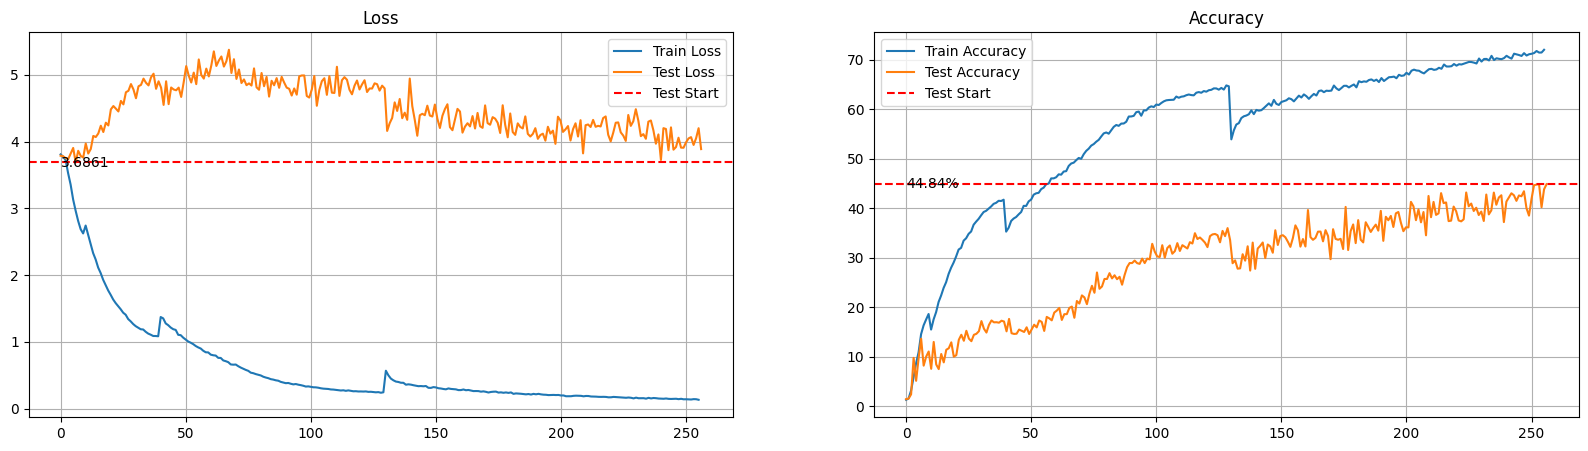

In [ ]:
# plot the training and testing loss and accuracy 
train_loss = [stat[0] for stat in train_stats]
train_acc =  [stat[1] for stat in train_stats]
test_loss =  [stat[0] for stat in test_stats ]
test_acc =   [stat[1] for stat in test_stats ]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(np.min(test_loss), color='r', linestyle='--', label='Test Start')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(np.max(test_acc), color='r', linestyle='--', label='Test Start')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()
peak_accuracy = np.max(test_acc)

In [ ]:
# Load the best model's state dictionary
model.load_state_dict(torch.load("best_v1dTransformer.pth"))

# Move the model to the appropriate device
model.to(global_device)

print("Best model loaded successfully.")

Best model loaded successfully.


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


Evaluation => Loss: 3.9444, Accuracy: 44.47%


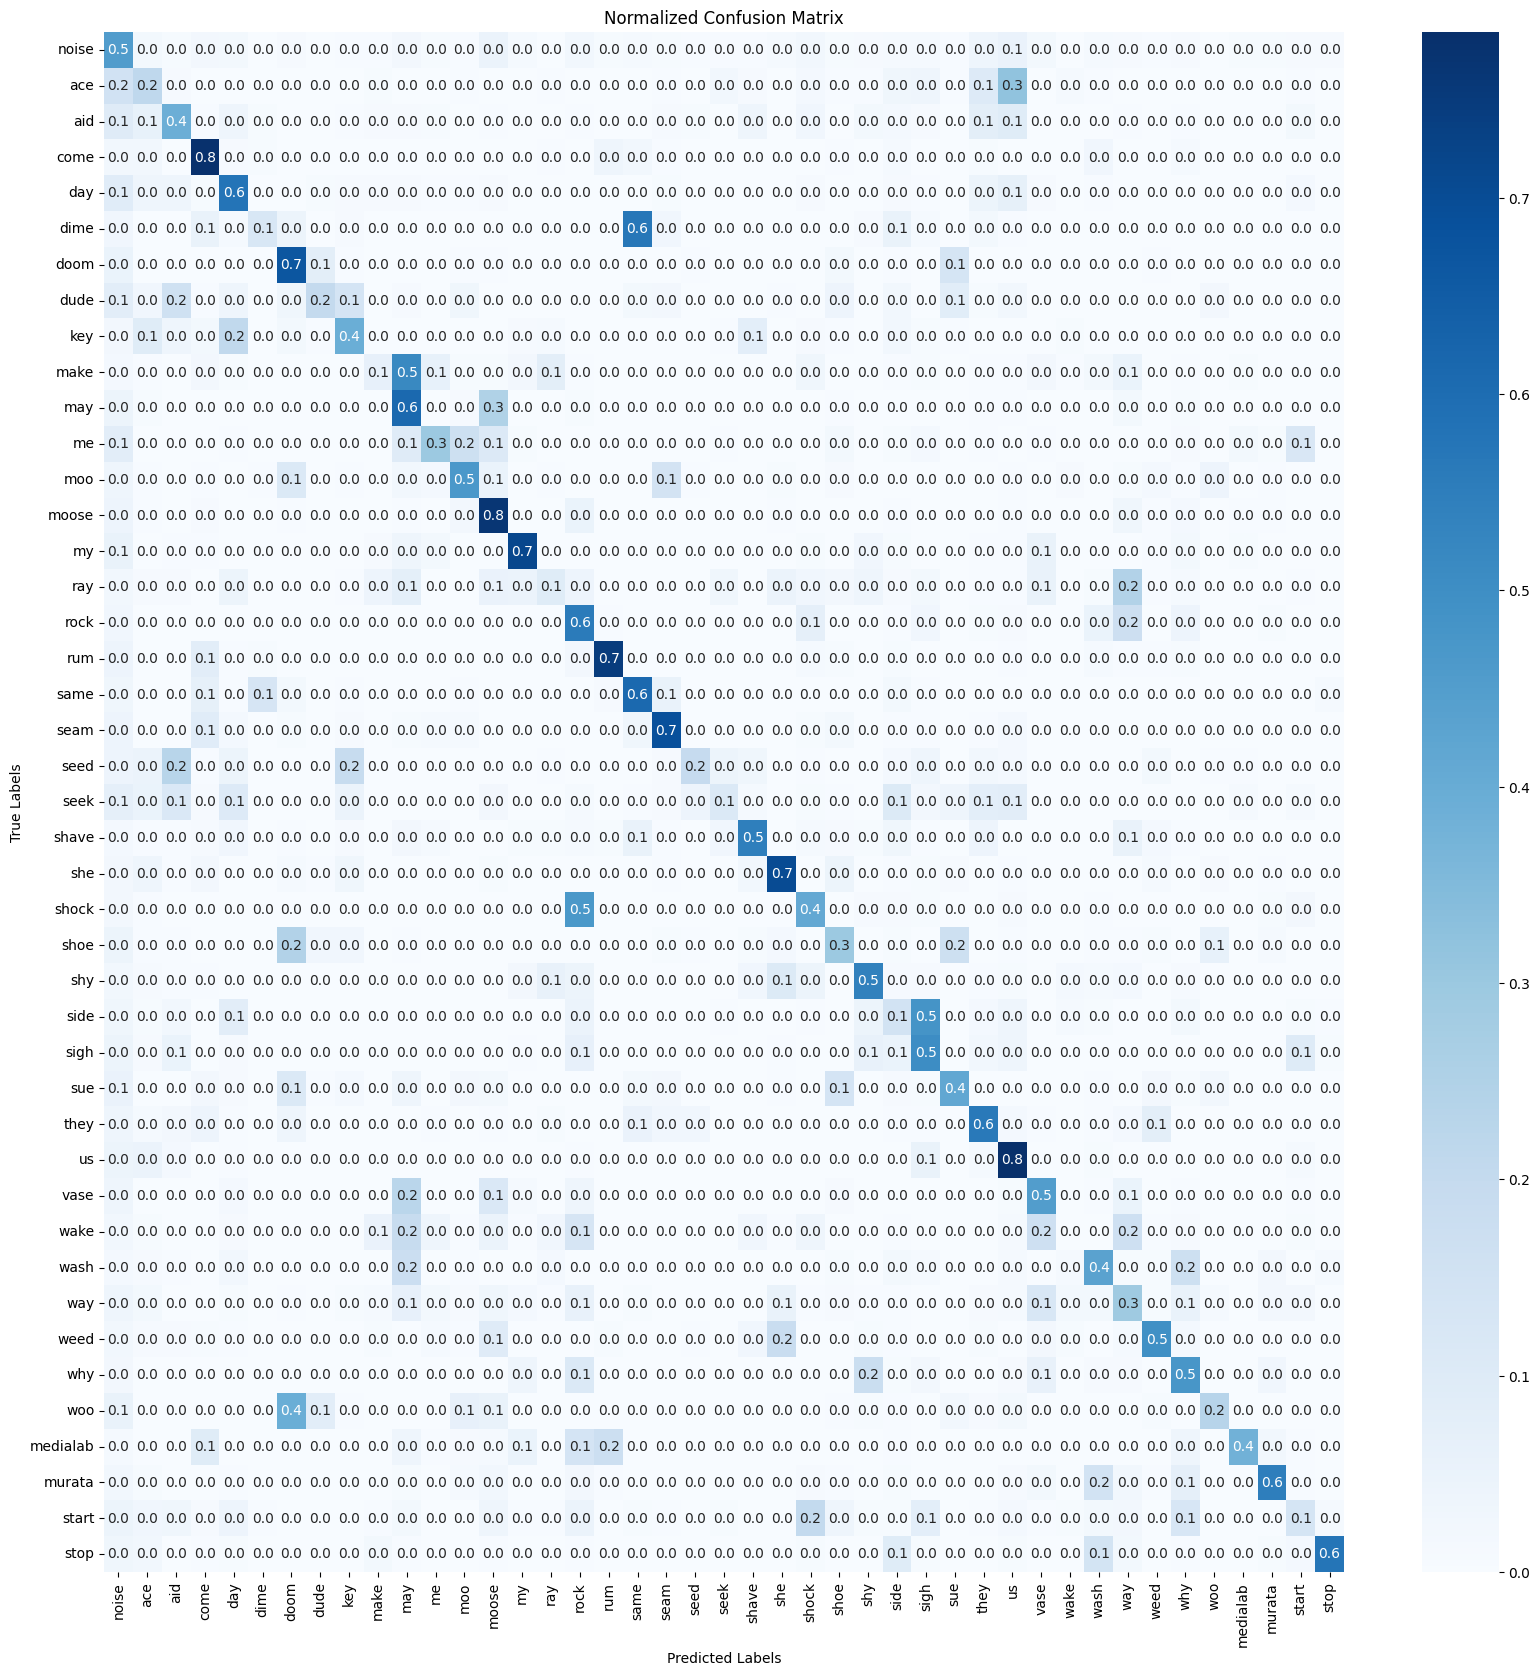

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

def evaluate_epoch(
    model,
    dataloader,
    dataset,  # used for `id_to_dataset()`
    loss_func,
    device='cpu',
    epochs=100,
    verbosity=1
):
    """
    Evaluate `model` for 1 epoch on `dataloader`.
    Returns (avg_loss, accuracy, confusion_matrix).
    """
    model.to(device)
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    num_batches = 0

    all_labels = []
    all_preds = []

    with torch.no_grad():
        for epoch in tqdm(range(epochs), desc="Evaluating", disable=(verbosity == 0)):
            for adc1, adc2, ids in dataloader:
                # Move to device
                adc1 = adc1.to(device)
                adc2 = adc2.to(device)
                ids  = ids.to(device)

                # Downsample IDs if needed
                ids = ids[:, ::model.input_kern]

                # Build input => shape [B, 2, T]
                adc = torch.stack((adc1, adc2), dim=1)

                # Forward pass => shape [B, T', C]
                logits = model(adc)

                B, T_prime, C = logits.shape
                logits_2d = logits.view(B * T_prime, C)
                ids_1d = ids.view(-1)

                # Loss
                loss = loss_func(logits_2d, ids_1d)
                total_loss += loss.item()

                # Accuracy
                pred = logits.argmax(dim=2)
                total_correct += (pred == ids).sum().item()
                total_tokens += (B * T_prime)
                num_batches += 1

                # Accumulate for confusion matrix
                all_labels.extend(ids_1d.cpu().tolist())
                all_preds.extend(pred.view(-1).cpu().tolist())

    avg_loss = total_loss / max(num_batches, 1)
    accuracy = 100.0 * total_correct / max(total_tokens, 1)

    # Build confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)
    conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1, keepdims=True)

    if verbosity > 0:
        print(f"Evaluation => Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

        # Display confusion matrix
        plt.figure(figsize=(20, 20))
        sns.heatmap(conf_mat_normalized, annot=True, fmt=".1f", cmap="Blues", xticklabels=dataset.dataset_map.keys(), yticklabels=dataset.dataset_map.keys())
        plt.title("Normalized Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

    return avg_loss, accuracy, conf_mat

# Evaluate the best model on the test dataset
best_model_stats = evaluate_epoch(
    model,
    val_loader,
    test_dataset,  # pass the test dataset for id_to_dataset()
    loss_func=criterion,
    device=global_device,
    verbosity=1
)

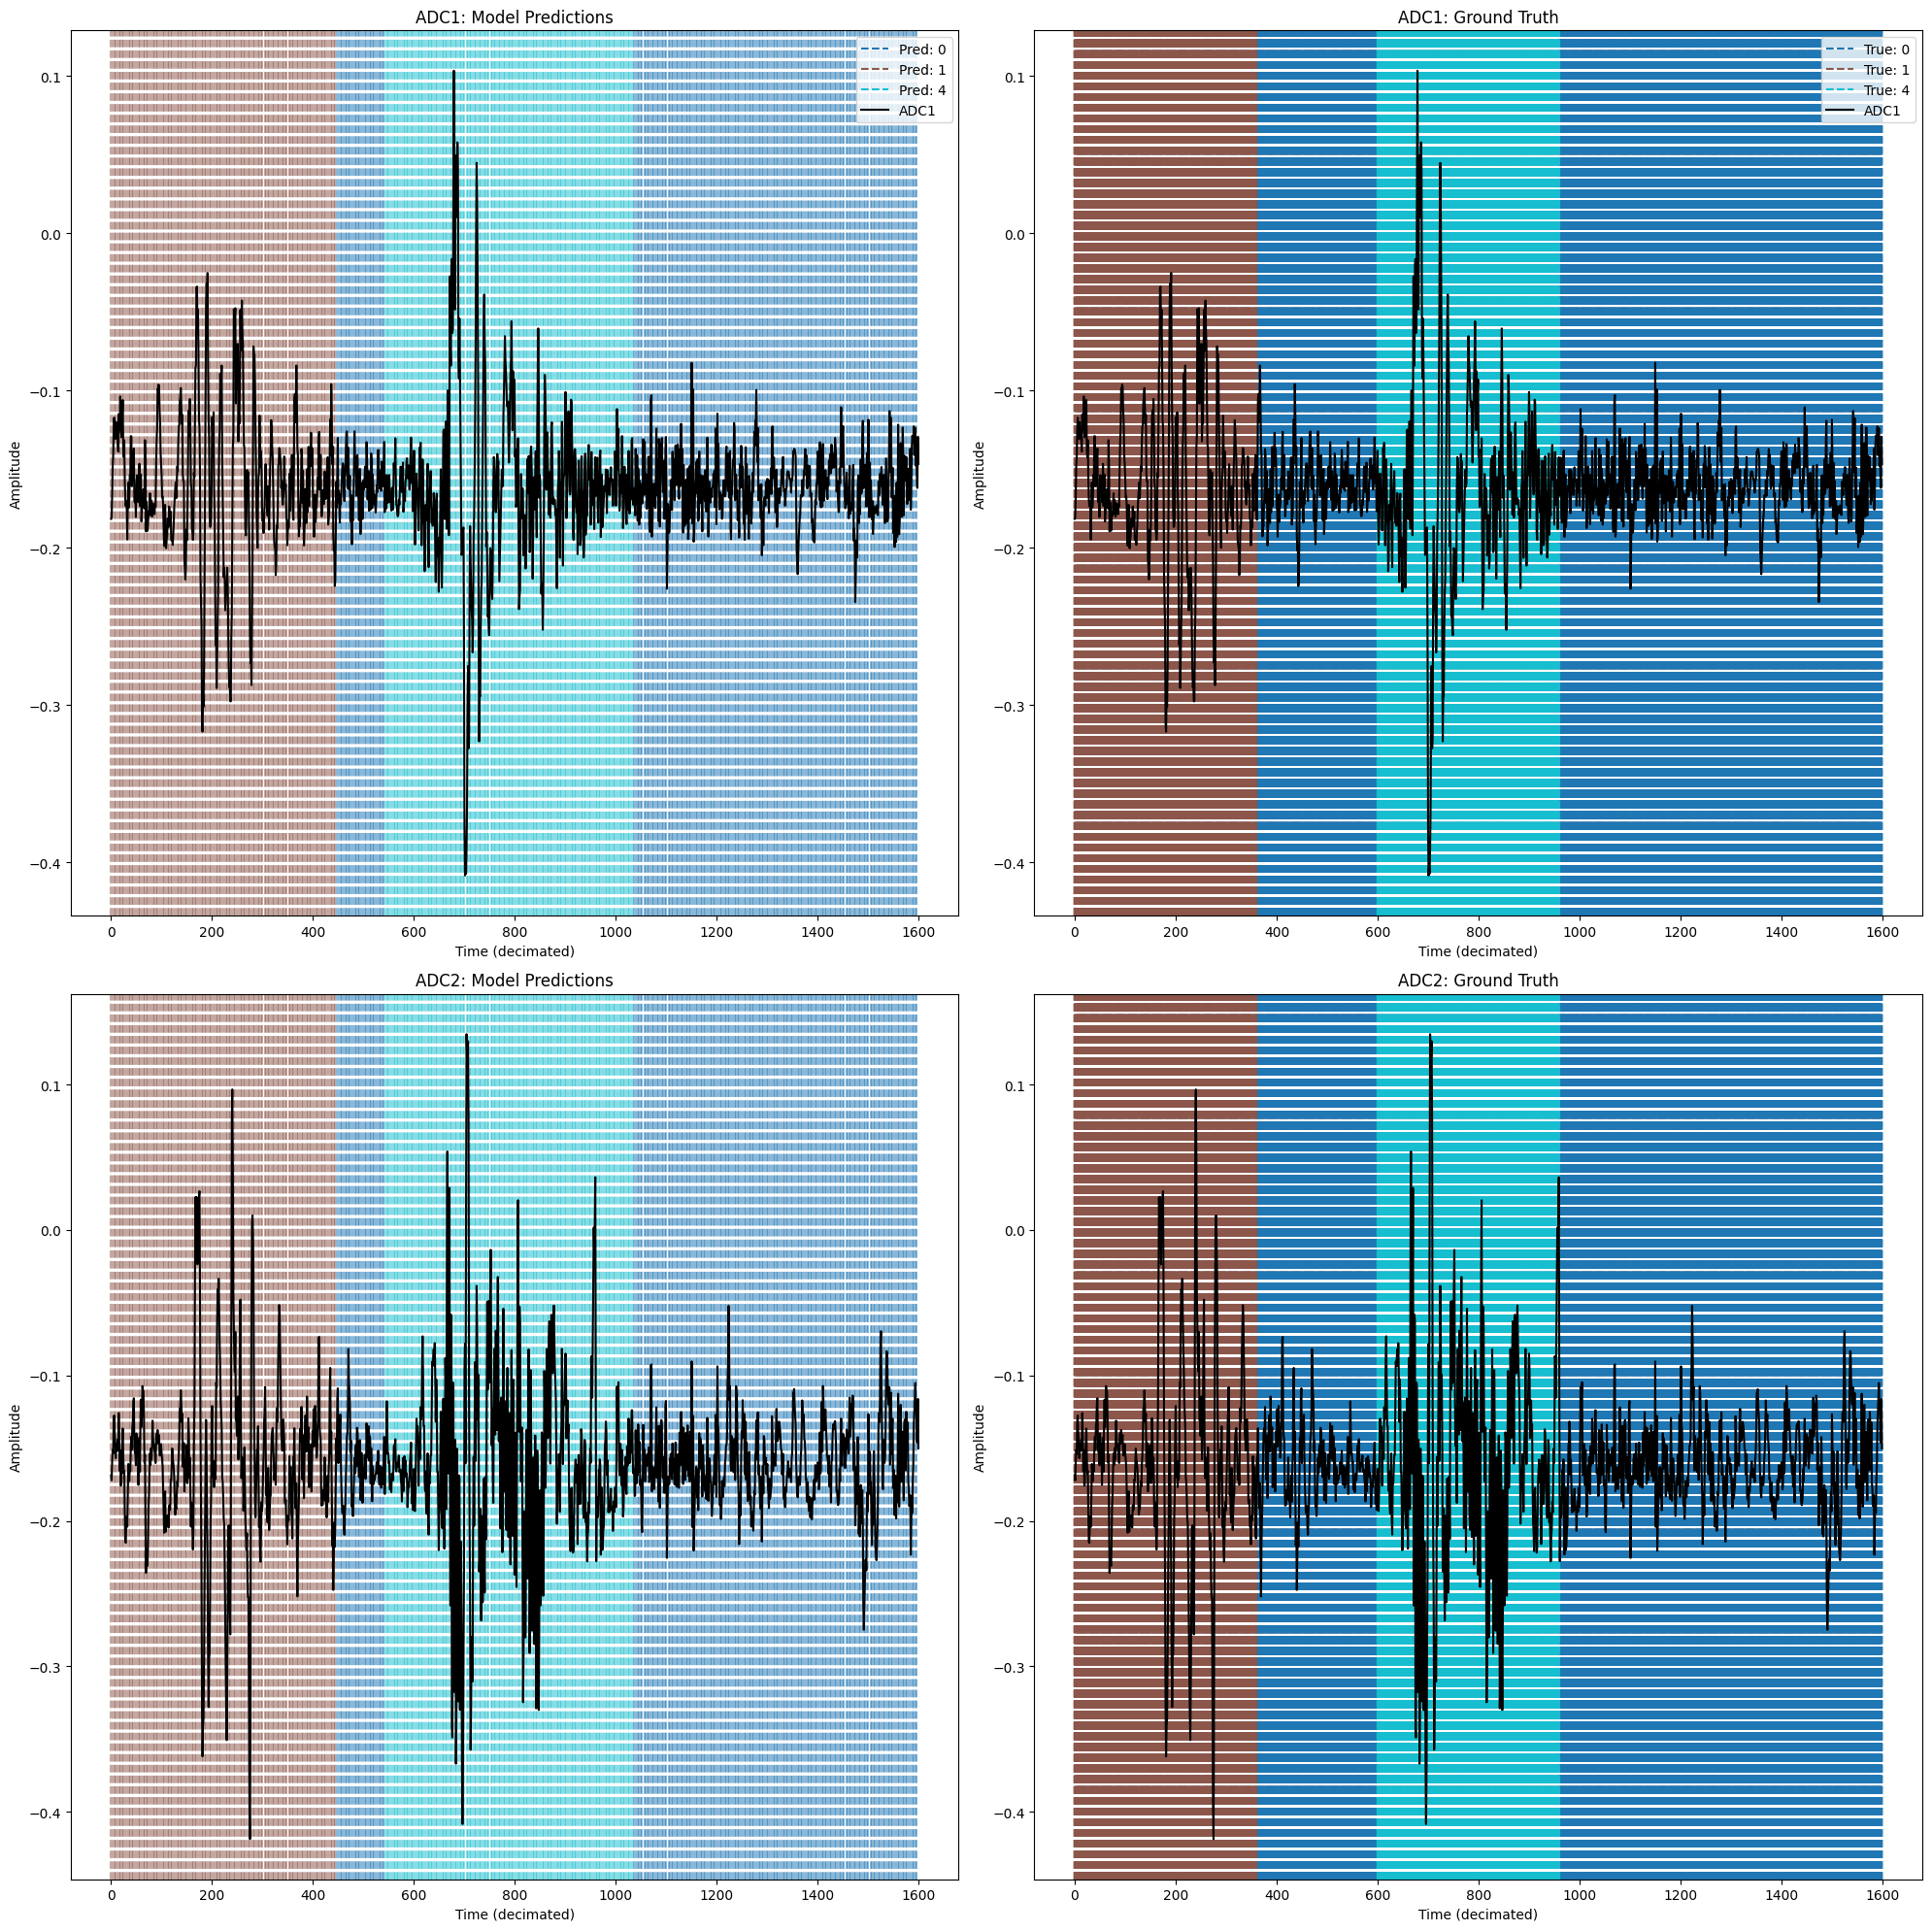

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import decimate

def visualize_model_predictions_with_groundtruth(model, dataset, device='cpu', n_decimate=10):
    """
    Visualize a random sample's signals (ADC1, ADC2) alongside
    1) the model's predicted labels (left column)
    2) the ground truth labels (right column)
    over time (shown as vertical lines), using consistent colors
    for the same class labels in both subplots.
    """
    model.eval()
    model.to(device)

    # Pick a random sample
    rng_index = np.random.randint(0, len(dataset))
    adc1, adc2, true_ids = dataset[rng_index]  # (Tensor, Tensor, Tensor) or similar

    # Convert signals to batch form: [B=1, 2, T]
    adc = torch.stack((adc1, adc2), dim=0).unsqueeze(0).to(device)  # shape: [1, 2, T]

    # Forward pass => [1, T_after_conv, output_dim]
    with torch.no_grad():
        logits = model(adc)
        # Argmax => [1, T_after_conv]
        pred = logits.argmax(dim=-1).squeeze(0).cpu()  # shape: [T_after_conv]

    # Decimate the signals for display
    adc1_decimated = decimate(adc1.numpy(), n_decimate, zero_phase=True)
    adc2_decimated = decimate(adc2.numpy(), n_decimate, zero_phase=True)

    # Grab unique IDs from both prediction and ground truth
    unique_preds = torch.unique(pred).numpy()
    true_ids_np = true_ids.numpy()
    unique_gts = np.unique(true_ids_np)

    # Build a combined sorted list of all possible IDs
    all_ids = np.unique(np.concatenate([unique_preds, unique_gts]))
    all_ids_sorted = sorted(all_ids)

    # Assign a color to each possible ID using a single shared colormap
    # (you can choose any colormap, e.g. tab10, Set1, etc.)
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(all_ids_sorted)))
    id_to_color = {id_val: color_palette[i] for i, id_val in enumerate(all_ids_sorted)}

    # Create a figure with 2 rows and 2 columns:
    #   Left column = predictions
    #   Right column = ground truth
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharex=False, sharey=False)

    # ------------------------------------------------------------------
    # LEFT COLUMN: MODEL PREDICTIONS
    # ------------------------------------------------------------------
    for pred_id in np.unique(pred):
        color = id_to_color[pred_id.item()]
        # Indices where pred == pred_id
        indices = (pred == pred_id).nonzero().flatten().cpu().numpy()
        # Map those indices to decimated plotting coordinates
        decimated_indices = (indices * getattr(model, 'input_kern', 1)) // n_decimate

        # Add vertical lines in both ADC1 and ADC2 subplots (left column)
        for idx in decimated_indices:
            axs[0, 0].axvline(x=idx, color=color, linestyle='--', alpha=0.5)
            axs[1, 0].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

        # Add a "dummy" line for the legend entry
        axs[0, 0].plot([], [], color=color, linestyle='--', label=f"Pred: {pred_id.item()}")

    # Plot decimated signals in the left column
    axs[0, 0].plot(adc1_decimated, color='black', label='ADC1')
    axs[0, 0].set_title("ADC1: Model Predictions")
    axs[0, 0].set_xlabel("Time (decimated)")
    axs[0, 0].set_ylabel("Amplitude")

    axs[1, 0].plot(adc2_decimated, color='black', label='ADC2')
    axs[1, 0].set_title("ADC2: Model Predictions")
    axs[1, 0].set_xlabel("Time (decimated)")
    axs[1, 0].set_ylabel("Amplitude")

    # Consolidate legend in top-left plot
    handles, labels = axs[0, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0, 0].legend(by_label.values(), by_label.keys(), loc='upper right')

    # ------------------------------------------------------------------
    # RIGHT COLUMN: GROUND TRUTH LABELS
    # ------------------------------------------------------------------
    for gt_id in unique_gts:
        color = id_to_color[gt_id]
        gt_indices = np.where(true_ids_np == gt_id)[0]
        # Map those original-sample indices to decimated coordinates
        decimated_gt_indices = gt_indices // n_decimate

        # Draw vertical lines in the right column
        for idx in decimated_gt_indices:
            axs[0, 1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)
            axs[1, 1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

        # Dummy line for legend
        axs[0, 1].plot([], [], color=color, linestyle='--', label=f"True: {gt_id}")

    # Plot the same decimated signals in the right column
    axs[0, 1].plot(adc1_decimated, color='black', label='ADC1')
    axs[0, 1].set_title("ADC1: Ground Truth")
    axs[0, 1].set_xlabel("Time (decimated)")
    axs[0, 1].set_ylabel("Amplitude")

    axs[1, 1].plot(adc2_decimated, color='black', label='ADC2')
    axs[1, 1].set_title("ADC2: Ground Truth")
    axs[1, 1].set_xlabel("Time (decimated)")
    axs[1, 1].set_ylabel("Amplitude")

    # Legend for the ground truth column
    handles_gt, labels_gt = axs[0, 1].get_legend_handles_labels()
    by_label_gt = dict(zip(labels_gt, handles_gt))
    axs[0, 1].legend(by_label_gt.values(), by_label_gt.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()
# Example usage:
visualize_model_predictions_with_groundtruth(model, dataset, device=global_device)